In [1]:
!git clone https://github.com/dunp7/Math_solving_using_LLM.git

Cloning into 'Math_solving_using_LLM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 25 (delta 7), reused 19 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 809.84 KiB | 27.92 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install -r /content/Math_solving_using_LLM/requirements.txt

Looking in indexes: https://download.pytorch.org/whl/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 25.0 MB/s eta 0:00:00


# Libraries

In [2]:
import random
import torch
import pickle
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, BitsAndBytesConfig
from datasets import load_from_disk
import sys
sys.path.append("/content/Math_solving_using_LLM")
sys.path.append("/content/Math_solving_using_LLM/my_utils")

from generate_results import generate_answers, generate_SE
from my_utils.data import load_ds, sample_ds, load_results
from my_utils.semantic_entropy import is_entailment_embeddings, is_entailment_transformer, is_entailment_llm
from my_utils.metrics import metric_entail_models
from my_utils.visualisations import visualise_aur_results, visualise_aur_percentages_results, visualise_SE_distribution, visualise_SE_mean_std


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
seed = 42
random.seed(seed)

C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


# Load datasets

In [ ]:
n_samples = 20
# _, triviaqa_val = load_ds("trivia_qa", seed)
# _, squad_val = load_ds("squad", seed)
_, svamp_val = load_ds("svamp", seed)
# _, nq_val = load_ds("nq", seed)


# triviaqa_sample = sample_ds(triviaqa_val, n_samples, seed, "trivia_qa")
# squad_sample = sample_ds(squad_val, n_samples, seed, "squad")
svamp_sample = sample_ds(svamp_val, n_samples, seed, "svamp")
# nq_sample = sample_ds(nq_val, n_samples, seed, "nq")
# del triviaqa_val, squad_val, svamp_val, nq_val
del svamp_val

# datasets = [triviaqa_sample, squad_sample, svamp_sample, nq_sample]
datasets = [svamp_sample]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/675 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/111k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/54.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/700 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Dataset:  svamp
Dataset({
    features: ['ID', 'Body', 'Question', 'Equation', 'Answer', 'Type', 'question_concat', 'question', 'context', 'type', 'equation', 'id', 'answers'],
    num_rows: 20
}) 



# Generate answers

In [7]:
# LLM
Gemma_model = AutoModelForCausalLM.from_pretrained("SmallDoge/Doge-160M-Instruct", trust_remote_code=True, device_map="auto", torch_dtype=torch.bfloat16)
Gemma_tokenizer = AutoTokenizer.from_pretrained("SmallDoge/Doge-160M-Instruct")

data_answer_path = "data/answers/"
generate_answers(datasets, data_answer_path, Gemma_model, Gemma_tokenizer)

del Gemma_model, Gemma_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

configuration_doge.py:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/SmallDoge/Doge-160M-Instruct:
- configuration_doge.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_doge.py:   0%|          | 0.00/55.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/SmallDoge/Doge-160M-Instruct:
- modeling_doge.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/611M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/139 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/56.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]


Generating responses for svamp dataset...


100%|██████████| 20/20 [04:06<00:00, 12.32s/it]


Flattening the indices:   0%|          | 0/20 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

# Load Answers

In [9]:
# triviaqa_sample = load_from_disk("data/answers/trivia_qa")
# squad_sample = load_from_disk("data/answers/squad")
svamp_sample = load_from_disk("data/answers/svamp")
# nq_sample = load_from_disk("data/answers/nq")
Gemma_tokenizer = AutoTokenizer.from_pretrained("SmallDoge/Doge-160M-Instruct")

# datasets = [triviaqa_sample, squad_sample, svamp_sample, nq_sample]
datasets = [svamp_sample]

# Calculate Semantic Entropy for different entailment models

## Sentence Embeddings

In [10]:
All_mpnet_model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(DEVICE)
All_mpnet_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
data_entail_path = "data/SE/transformers/all_mpnet_base_v2/109M/"
print("\nAll-mpnet-base-v2")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, All_mpnet_model, All_mpnet_tokenizer, is_entailment_embeddings)
del All_mpnet_model, All_mpnet_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]


All-mpnet-base-v2

Generating Semantic Entropies for svamp dataset...


100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

## Transformers

In [11]:
Roberta_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli").to(DEVICE)
Roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
data_entail_path = "data/SE/transformers/roberta/356M/"
print("\nRoberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Roberta_model, Roberta_tokenizer, is_entailment_transformer)
del Roberta_model, Roberta_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Roberta

Generating Semantic Entropies for svamp dataset...


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [12]:
Deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large").to(DEVICE)
Deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
data_entail_path = "data/SE/transformers/deberta/304M/"
print("\nDeberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Deberta_model, Deberta_tokenizer, is_entailment_transformer)
del Deberta_model, Deberta_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Deberta

Generating Semantic Entropies for svamp dataset...



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [13]:
mem_b = torch.cuda.memory_allocated()
Deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large").to(DEVICE)
Deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
mem_a = torch.cuda.memory_allocated()
print(mem_a -mem_b)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0


In [14]:
Deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v2-xxlarge-mnli").to(DEVICE)
Deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge-mnli")
data_entail_path = "data/SE/transformers/deberta/1.5B/"
print("\nDeberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Deberta_model, Deberta_tokenizer, is_entailment_transformer)
del Deberta_model, Deberta_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.45M [00:00<?, ?B/s]


Deberta

Generating Semantic Entropies for svamp dataset...



100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

## LLMs

### Qwen

In [15]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
data_entail_path = "data/SE/llms/qwen/0.5B/"
print("\nQwen 0.5B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]


Qwen 0.5B

Generating Semantic Entropies for svamp dataset...


100%|██████████| 20/20 [10:55<00:00, 32.78s/it]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [16]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
data_entail_path = "data/SE/llms/qwen/1.5B/"
print("\nQwen 1.5B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]


Qwen 1.5B

Generating Semantic Entropies for svamp dataset...


100%|██████████| 20/20 [01:53<00:00,  5.70s/it]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

In [17]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-3B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
data_entail_path = "data/SE/llms/qwen/3.0B/"
print("\nQwen 3B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]


Qwen 3B

Generating Semantic Entropies for svamp dataset...


100%|██████████| 20/20 [13:10<00:00, 39.52s/it]


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

### Gemma

In [18]:
# Gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", torch_dtype="auto", device_map="auto")
# data_entail_path = "data/SE/llms/gemma/2.0B/"
# print("\nGemma 2.0B")
# generate_SE(datasets, data_entail_path, Gemma_tokenizer, Gemma_model, Gemma_tokenizer, is_entailment_llm)
# del Gemma_model
# torch.cuda.empty_cache()

In [19]:
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# Gemma_model_8bit = AutoModelForCausalLM.from_pretrained("google/gemma-2-9b-it", quantization_config=quantization_config, torch_dtype="auto", low_cpu_mem_usage=True)
# Gemma_tokenizer_8bit = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
# data_entail_path = "data/SE/llms/gemma/9.0B/"
# print("\nGemma 9.0B")
# generate_SE(datasets, data_entail_path, Gemma_tokenizer, Gemma_model_8bit, Gemma_tokenizer_8bit, is_entailment_llm)
# del Gemma_model_8bit, Gemma_tokenizer_8bit
# torch.cuda.empty_cache()

### Llama

In [20]:
# Llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct").to(DEVICE)
# Llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
# data_entail_path = "data/SE/llms/llama3_2/1.0B/"
# print("\nLlama 3.2 1B")
# generate_SE(datasets, data_entail_path, Gemma_tokenizer, Llama_model, Llama_tokenizer, is_entailment_llm)
# del Llama_model, Llama_tokenizer
# torch.cuda.empty_cache()

# Load Results

In [1]:
transformers_results, transformers_names = load_results("data/SE/transformers", "Transformer")
# llm_results, llm_names = load_results("data/SE/llms", "LLM")

transformers_names[0] = "Transformer All-MPNet 109M"
# datasets_names = ["NQ Open", "SQuAD", "SVAMP", "Trivia QA"]
datasets_names = ["SVAMP"]

# models_names = transformers_names + llm_names
models_names = transformers_names



unique_models = list(set(models_names))
unique_models.sort()

colours = [
    "#56B4E9",  # Sky Blue
    "#FF0000",  # Red
    "#F0E442",  # Yellow
    "#882255",  # Deep Purple
    "#0072B2",  # Blue
    "#009E73",  # Green
    "#D55E00",  # Orange
    "#99E699",  # Light Green
    "#CC79A7",  # Pink
]

model_to_colour = {model: colour for model, colour in zip(unique_models, colours)}

NameError: name 'load_results' is not defined

# Calculate Metrics

## AUROC


AUROC scores for All_mpnet_base_v2 109M
svamp                dataset:   0.5000

AUROC scores for Deberta 1.5B
svamp                dataset:   0.3646

AUROC scores for Deberta 304M
svamp                dataset:   0.3229

AUROC scores for Roberta 356M
svamp                dataset:   0.6146

AUROC scores for Qwen 0.5B
svamp                dataset:   0.6146

AUROC scores for Qwen 1.5B
svamp                dataset:   0.4271

AUROC scores for Qwen 3.0B
svamp                dataset:   0.4583


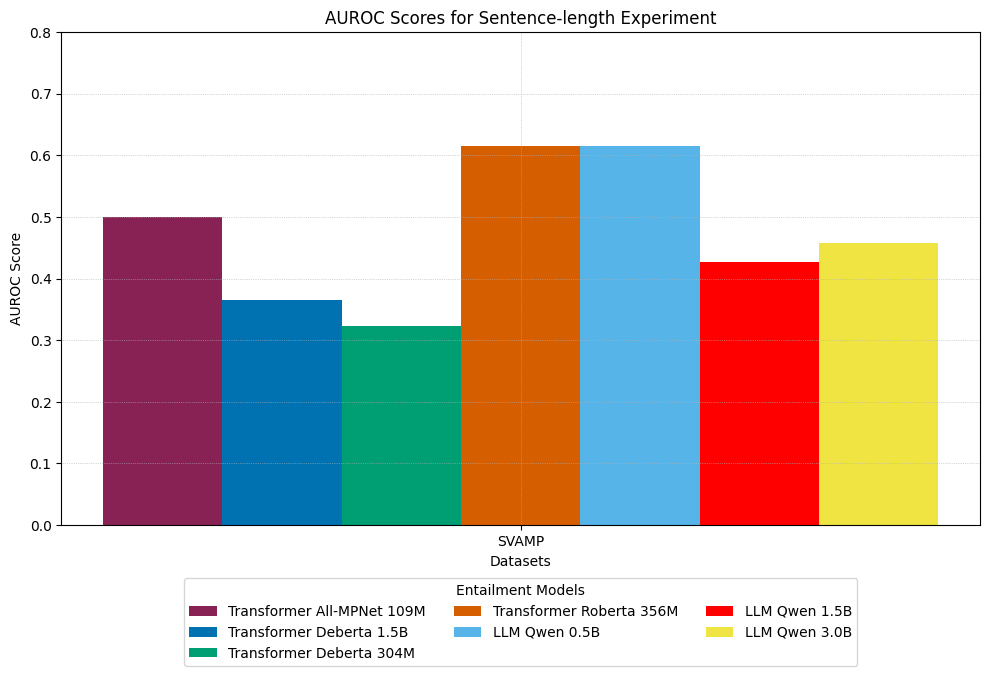

In [ ]:
auroc_tr = metric_entail_models(transformers_results, "AUROC")
# auroc_lr = metric_entail_models(llm_results, "AUROC")

# visualise_aur_results(models_names, datasets_names, auroc_tr + auroc_lr, model_to_colour, "AUROC")
visualise_aur_results(models_names, datasets_names, auroc_tr, model_to_colour, "AUROC")

## Semantic Entropy

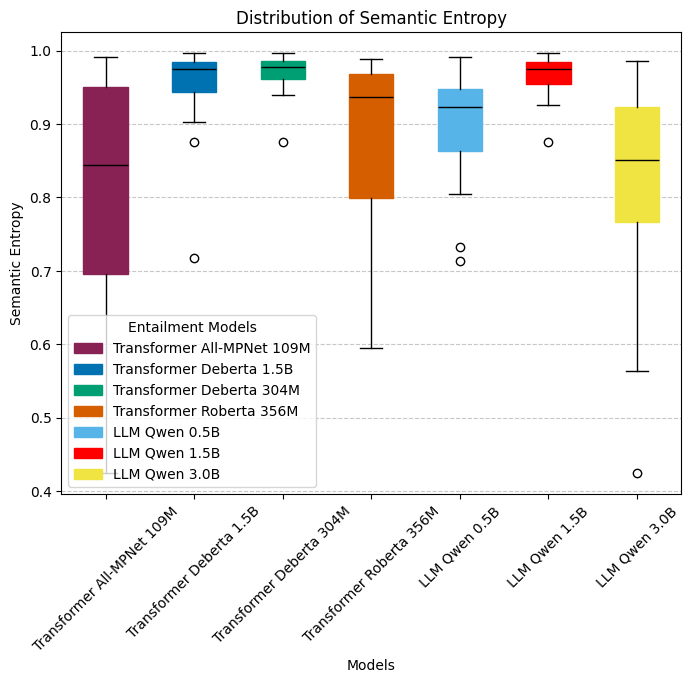

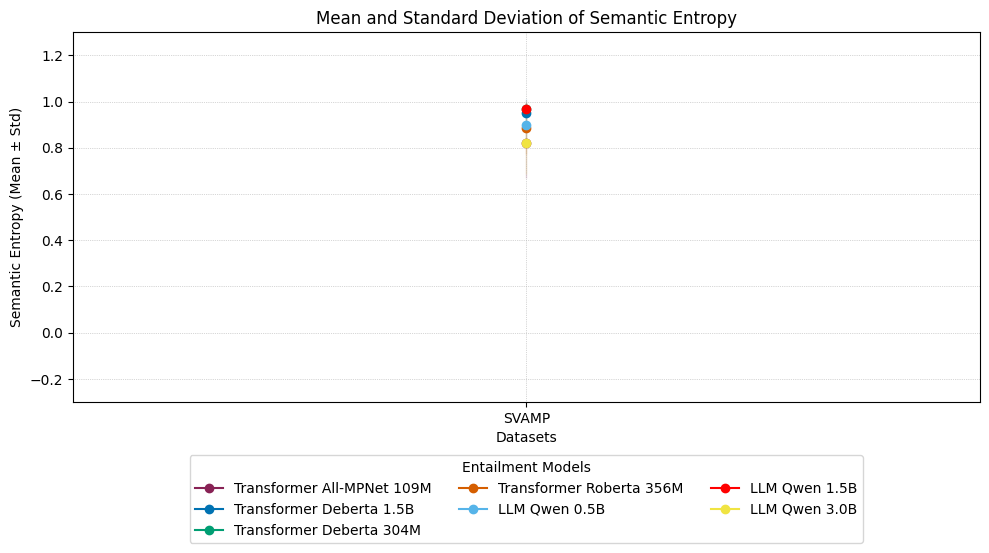

In [ ]:
SE_tr = metric_entail_models(transformers_results, "SE")
# SE_lr = metric_entail_models(llm_results, "SE")

# visualise_SE_distribution(models_names, datasets_names, SE_tr+SE_lr, model_to_colour)
visualise_SE_distribution(models_names, datasets_names, SE_tr, model_to_colour)



## AURAC


AURAC scores for All_mpnet_base_v2 109M
svamp                dataset:   0.6503

AURAC scores for Deberta 1.5B
svamp                dataset:   0.4378

AURAC scores for Deberta 304M
svamp                dataset:   0.4014

AURAC scores for Roberta 356M
svamp                dataset:   0.5392

AURAC scores for Qwen 0.5B
svamp                dataset:   0.6810

AURAC scores for Qwen 1.5B
svamp                dataset:   0.4567

AURAC scores for Qwen 3.0B
svamp                dataset:   0.5832


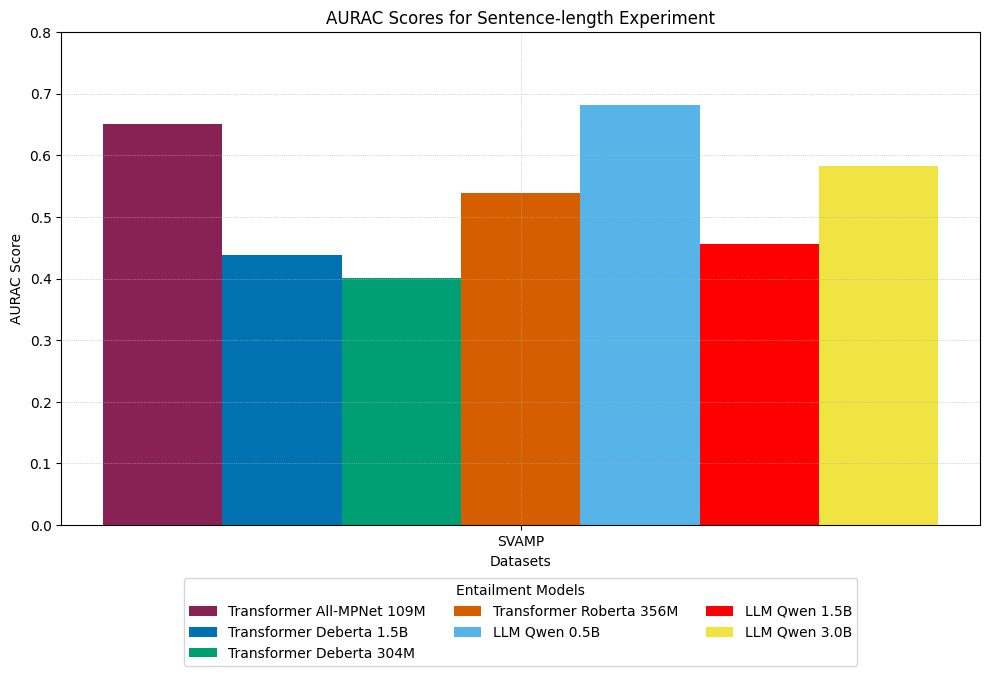

In [ ]:
aurac_tr = metric_entail_models(transformers_results, "AURAC")
# aurac_lr = metric_entail_models(llm_results, "AURAC")

visualise_aur_results(models_names, datasets_names, aurac_tr, model_to_colour, "AURAC")
# visualise_aur_results(models_names, datasets_names, aurac_tr+aurac_lr, model_to_colour, "AURAC")


AURAC % scores for All_mpnet_base_v2 109M
svamp                dataset:   0.6503

AURAC % scores for Deberta 1.5B
svamp                dataset:   0.4378

AURAC % scores for Deberta 304M
svamp                dataset:   0.4014

AURAC % scores for Roberta 356M
svamp                dataset:   0.5392

AURAC % scores for Qwen 0.5B
svamp                dataset:   0.6810

AURAC % scores for Qwen 1.5B
svamp                dataset:   0.4567

AURAC % scores for Qwen 3.0B
svamp                dataset:   0.5832


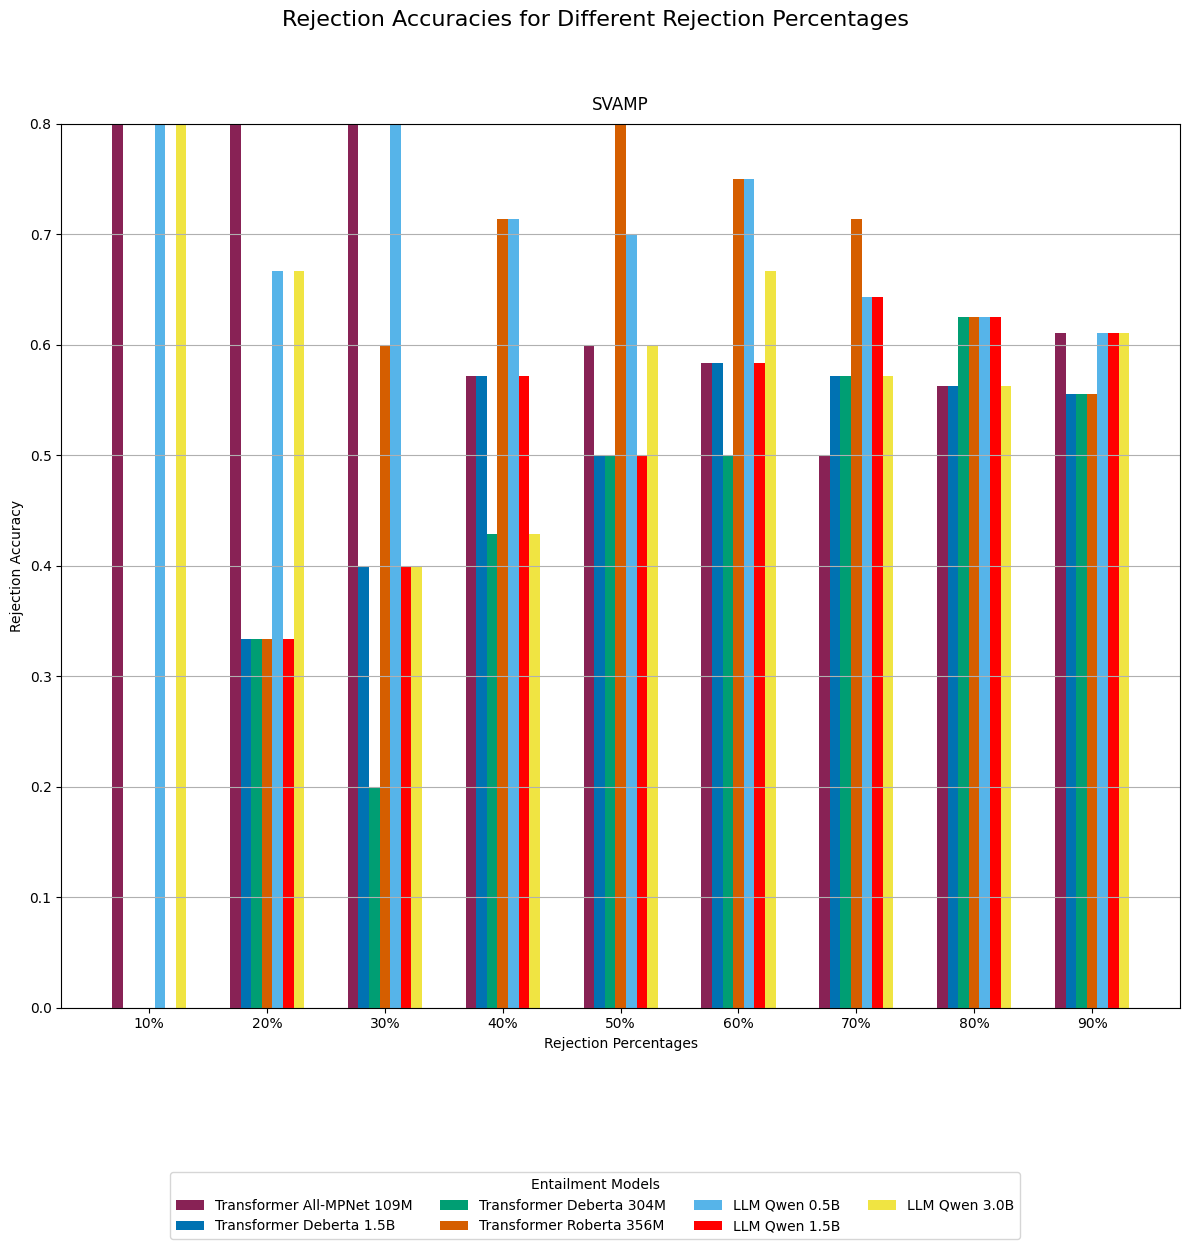

In [ ]:
# aurac_per_tr = metric_entail_models(transformers_results, "AURAC %")
# aurac_per_lr = metric_entail_models(llm_results, "AURAC %")

# visualise_aur_percentages_results(models_names, datasets_names, aurac_per_tr+aurac_per_lr, model_to_colour)

## F1-score


F1 scores for All_mpnet_base_v2 109M
svamp                dataset:   0.7097

F1 scores for Deberta 1.5B
svamp                dataset:   0.7500

F1 scores for Deberta 304M
svamp                dataset:   0.7500

F1 scores for Roberta 356M
svamp                dataset:   0.7500

F1 scores for Qwen 0.5B
svamp                dataset:   0.7500

F1 scores for Qwen 1.5B
svamp                dataset:   0.7500

F1 scores for Qwen 3.0B
svamp                dataset:   0.7742


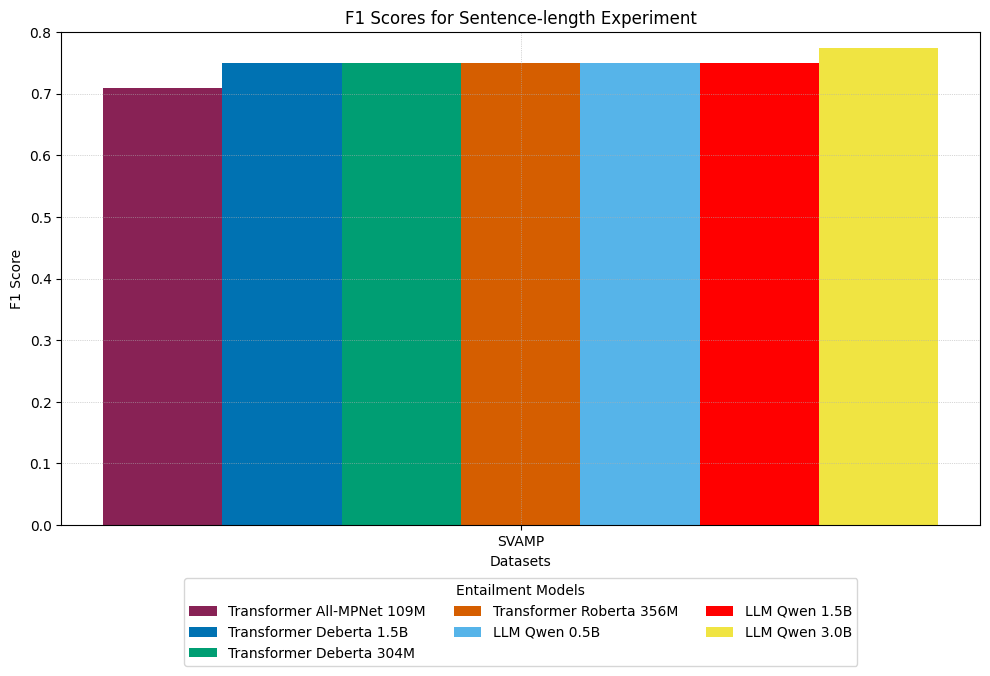

In [ ]:
# f1_tr = metric_entail_models(transformers_results, "F1")
# f1_lr = metric_entail_models(llm_results, "F1")

# visualise_aur_results(models_names, datasets_names, f1_tr+f1_lr, model_to_colour, "F1")

## Memory

In [ ]:
# mem_tr = metric_entail_models(transformers_results, "MEMORY")
# mem_lr = metric_entail_models(llm_results, "MEMORY")


Memory allocation in MB for All_mpnet_base_v2 109M
svamp      |  Mean:    5.112    Std:   2.030

Memory allocation in MB for Deberta 1.5B
svamp      |  Mean: 14185.182    Std: 6022.854

Memory allocation in MB for Deberta 304M
svamp      |  Mean: 4986.776    Std: 2208.706

Memory allocation in MB for Roberta 356M
svamp      |  Mean: 1819.465    Std: 925.253

Memory allocation in MB for Qwen 0.5B
svamp      |  Mean:    0.063    Std:   0.014

Memory allocation in MB for Qwen 1.5B
svamp      |  Mean:    0.054    Std:   0.015

Memory allocation in MB for Qwen 3.0B
svamp      |  Mean:    0.059    Std:   0.014


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import shutil

# source_folder = '/content/data'
# destination_folder = '/content/drive/My Drive/Math Solving Problem/data'

# shutil.copytree(source_folder, destination_folder)
# print(f"Folder copied to {destination_folder}")

Mounted at /content/drive
Folder copied to /content/drive/My Drive/Math Solving Problem/data
